In [ ]:
#!pip install catboost
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.cluster import KMeans

from sklearn import linear_model
from sklearn import ensemble
from sklearn import svm
import xgboost as xgb
import lightgbm as lgbm
#import catboost as cb

#import optuna

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sub = pd.read_csv('sample_submission.csv')
target = train['yield']
train.drop('id',inplace=True, axis=1)
test.drop('id', inplace=True, axis=1)
train.drop('yield', inplace=True, axis=1)

In [ ]:
to_cat = ['clonesize', 'honeybee', 'bumbles', 'andrena', 'osmia', 'MaxOfUpperTRange','AverageRainingDays']
for cat in to_cat:
    unique_values = np.unique(np.concatenate((train[cat].unique(), test[cat].unique())))
    train[cat] = pd.Categorical(train[cat], categories=unique_values, ordered=True)
    test[cat] = pd.Categorical(test[cat], categories=unique_values, ordered=True)
    train[cat] = train[cat].cat.codes
    test[cat] = test[cat].cat.codes

In [ ]:
dropp = [
    'MinOfUpperTRange', 'AverageOfUpperTRange',
    'MaxOfLowerTRange', 'MinOfLowerTRange', 'AverageOfLowerTRange',
    'RainingDays'
]
train.drop(dropp, inplace=True, axis=1)
test.drop(dropp, inplace=True, axis=1)

In [ ]:
kmeans = KMeans(n_clusters = 4)
kmeans.fit(train)
train['cluster'] = kmeans.predict(train)
test['cluster'] = kmeans.predict(test)

In [ ]:
models = {
    #'logistic_regression': linear_model.LogisticRegression(),
    'lasso': linear_model.LassoCV(),
    'ridge': linear_model.RidgeCV(),
    #'svc': svm.SVR(),
    #'randomforest': ensemble.RandomForestRegressor(),
    'gradientboosting': ensemble.GradientBoostingRegressor(),
    'xgboost': xgb.XGBRegressor(),
    'lightgbm': lgbm.LGBMRegressor(objective='MAE'),
    'catboost' : cb.CatBoostRegressor(iterations=300, depth=6, silent=True, objective='MAE')
}

In [ ]:
search_cat = target.unique()
search_cat.sort()

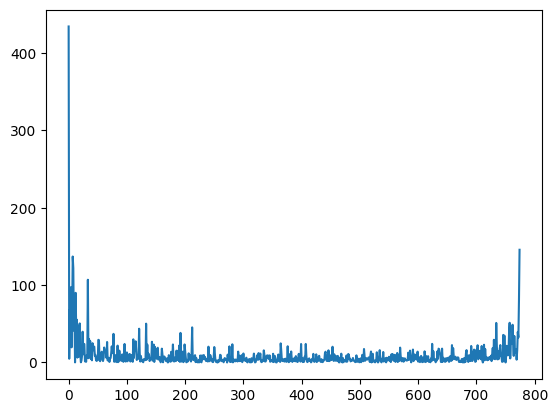

In [ ]:
plt.plot([i for i in range(775)], [search_cat[i]-search_cat[i-1] for i in range(1,776)])
plt.show()

In [ ]:
def GetCatScore(x):
    global search_cat
    low, high, mid = 0, 775, 0
    while (low <= high):
        mid = (low + high) // 2
        if (search_cat[mid] > x):
            high = mid - 1
        else:
            low = mid + 1
    if (mid == 0):
        if (2*x < search_cat[0] + search_cat[1]):
            return search_cat[0]
        else:
            return search_cat[1]
    elif (mid == 775):
        if (2*x < search_cat[774] + search_cat[775]):
            return search_cat[774]
        else:
            return search_cat[775]
    else:
        score_1, score_2, score_3 = abs(search_cat[mid-1]-x), abs(search_cat[mid]-x), abs(search_cat[mid+1]-x)
        if (score_1 < score_2 and score_1 < score_3):
            return search_cat[mid-1]
        elif (score_2 < score_1 and score_2 < score_3):
            return search_cat[mid]
        else:
            return search_cat[mid+1]

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(train, target, random_state = 42)

for name, model in models.items():
    print(f'{name} : {kfold(model, train, target)}')

lasso : 402.5094524656066
ridge : 372.18442038877583
randomforest : 367.49462020400847
gradientboosting : 354.6407880410584
xgboost : 369.7502604444274
lightgbm : 343.74385121571373
catboost : 348.82676185144453


In [ ]:
lgbm_base_cat_pred = [GetCatScore(n) for n in lgbm.LGBMRegressor().fit(train, target).predict(test)]

In [ ]:
lgbm_base_cat_categorical = sub.copy()
lgbm_base_cat_categorical['yield'] = lgbm_base_cat_pred
lgbm_base_cat_categorical.to_csv('lgbm_categorical_base.csv', columns=['id', 'yield'], index=False)

lasso: 372.220
ridge: 372.287
randomforest: 368.831
gradientboosting: 355.006
xgboost: 371.046
lightgbm: 344.342
catboost: 348.622

In [ ]:
def obj(trial):
    params = {#"device": "gpu",
              "n_jobs": -1,
              "verbose": -1,
              "n_estimators": trial.suggest_int("n_estimators", 100,1000),
              "boosting_type": 'gbdt',
              "learning_rate": trial.suggest_float("learning_rate", 1e-4, 1e-1), 
              "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 1.0),
              "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 1.0),        
              "max_depth": trial.suggest_int("max_depth", 2, 10),
              "num_leaves": trial.suggest_int("num_leaves", 40,50),
              "colsample_bytree":trial.suggest_float("colsample_bytree",0.8, 0.9),
              "subsample":trial.suggest_float("subsample", 0.8,0.9),
              #"subsample_freq": 100,
              "objective": "regression_l1",
              "metric" : "mae"
    }
    model = lgbm.LGBMRegressor(**params)
    return kfold(model, train, target)

study_lgbm = optuna.create_study(direction = 'minimize')
study_lgbm.optimize(obj, n_trials=50)

[I 2023-05-09 08:15:00,437] A new study created in memory with name: no-name-95357f35-beb9-4d19-a5a3-2745b70d57e7
[I 2023-05-09 08:15:14,093] Trial 0 finished with value: 351.01329214723717 and parameters: {'n_estimators': 642, 'learning_rate': 0.017989772017587488, 'reg_alpha': 0.6070646774233364, 'reg_lambda': 0.6521946990355705, 'max_depth': 2, 'num_leaves': 46, 'colsample_bytree': 0.8412880650943079, 'subsample': 0.8676488975409486}. Best is trial 0 with value: 351.01329214723717.
[I 2023-05-09 08:15:42,857] Trial 1 finished with value: 343.03451526110985 and parameters: {'n_estimators': 938, 'learning_rate': 0.06634836321561477, 'reg_alpha': 0.5902872777717375, 'reg_lambda': 0.13850532053614462, 'max_depth': 4, 'num_leaves': 40, 'colsample_bytree': 0.804931617784558, 'subsample': 0.8007204869208107}. Best is trial 1 with value: 343.03451526110985.
[W 2023-05-09 08:15:49,843] Trial 2 failed with parameters: {'n_estimators': 270, 'learning_rate': 0.08935039240566468, 'reg_alpha': 0.

KeyboardInterrupt: ignored

In [ ]:
params = {'objective': 'regression_l1',
              'metric': 'mae',
              'num_leaves': 44,
              'learning_rate': 0.04445863394410189,
              'n_estimators': 1583,
              #'min_child_samples': int(min_child_samples),
              #'subsample': subsample,
              'force_col_wise': True,
              'verbosity': -1}

In [ ]:
print(kfold(lgbm.LGBMRegressor(**params), train, target))

344.7724415115521


In [ ]:
predction = prediction/25

In [ ]:
predction = [GetCatScore(n) for n in predction]

In [ ]:
lgbm_cv_train_cate = sub.copy()
lgbm_cv_train_cate['yield'] = predction
lgbm_cv_train_cate.to_csv('lgbm_cv_train_cate.csv', columns=['id', 'yield'], index=False)

In [ ]:
lgbm_pred = sub.copy()
lgbm_pred['yield'] = lgbm.LGBMRegressor(**params).fit(train, target).predict(test)

In [ ]:
lgbm_pred.to_csv('lgbm_categorical_tune.csv', columns=['id', 'yield'], index=False)

In [ ]:
print(mae(lgbm_pred['yield'], lgbm_base_cat_categorical['yield']))

52.057328213775634


In [ ]:
sub

In [ ]:
pred

In [ ]:
def tuner(trial):    
    params = {        
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth":trial.suggest_int("max_depth", 4, 10),
        "min_child_weight": trial.suggest_int("min_child_weight", 7, 8),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True), 
        "subsample": trial.suggest_float("subsample", 0.7, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-2, 10.),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-2, 10.),
        "gamma": trial.suggest_float("gamma", 0.7, 1.0, step=0.1),
    }    

    model = xgb.XGBRegressor(
        **params,
        n_jobs=-1, 
        objective='reg:squarederror',
        tree_method='gpu_hist',
        predictor = 'gpu_predictor',
        gpu_id = 0,
        enable_categorical = True
    )

    return -cross_val_score(model, train, target, cv = 5, scoring = 'neg_mean_absolute_error').mean()
    

study_xgb = optuna.create_study(direction = 'minimize')
study_xgb.optimize(tuner, n_trials=50)

In [ ]:
def objective(trial):
    model = CatBoostRegressor(
        iterations=trial.suggest_int("iterations", 100, 1000),
        learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        depth=trial.suggest_int("depth", 4, 10),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        bootstrap_type=trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
        random_strength=trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 10.0),
        od_type=trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        od_wait=trial.suggest_int("od_wait", 10, 50),
        verbose=False,
        objective='MAE'
    )
    return -cross_val_score(model, train, target, cv = 5, scoring = 'neg_mean_absolute_error').mean()

study_cb = optuna.create_study(study_name="catboost", direction="minimize")
study_cb.optimize(objective, n_trials=50)

In [ ]:
cb_pred = sub.copy()
cb_pred['yield'] = CatBoostRegressor(**study_cb.best_params).fit(train, target).predict(test)

In [ ]:
sub['yield'] = (cb_pred['yield']+lgbm_pred['yield'])/2

In [ ]:
sub.to_csv('cb_lgbm_ensemble.csv', columns=['id', 'yield'], index=False)